# Compare the effective bit width of ADPQ 

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [67]:
symmetrical_quantization = True
bit_quantization = 4
group_size = 128
alpha = 0.09

model_size = 8*10**9 # Llama 3.1 8B
original_size_bytes = model_size * 2 # fp16

In [68]:
# All weights are quantized to 4-bit
def get_total_size_bytes(model_size, bit_quantization, group_size, alpha, symmetrical_quantization):
    quantized_weight_size_bytes = model_size * bit_quantization / 8

    scale_size_bytes = model_size / group_size * 2 # fp16 scales
    zero_point_size_bytes = 0 if symmetrical_quantization else model_size / group_size * 1 # int8 zero points

    index_outlier_size_bytes = model_size * alpha * np.log2(group_size) / 8 # bits to bytes, assuming ideal quantization

    total_size_bytes = quantized_weight_size_bytes + scale_size_bytes + zero_point_size_bytes + index_outlier_size_bytes
    
    effective_bits = total_size_bytes / model_size * 8
    
    return total_size_bytes, effective_bits, (scale_size_bytes, zero_point_size_bytes, index_outlier_size_bytes)

In [69]:
total_size_bytes, effective_bits, breakdown = get_total_size_bytes(model_size, bit_quantization, group_size, alpha, symmetrical_quantization)
effective_bits

np.float64(4.755)

## Plot

In [70]:
SoTA = {
    "RTN": 4.25,
    "AWQ": 4.27,
    "SpQR": 4.63,
    "BnB": 5.7 * 10**9 / (model_size) *8
}

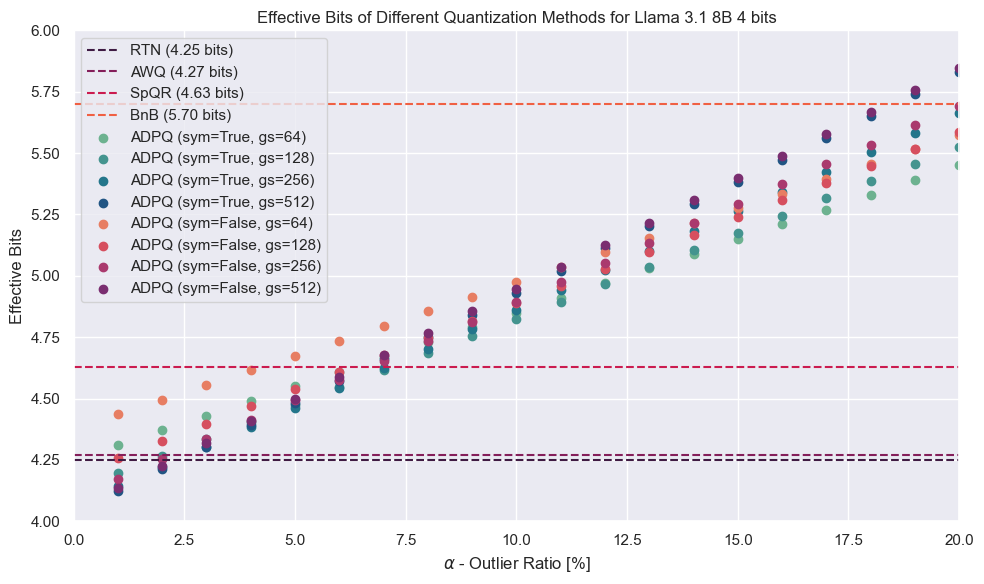

In [71]:
fig, ax = plt.subplots(figsize=(10,6))

# horizontal line for SoTA
colors = sns.color_palette("rocket", len(SoTA)+1)
for i, (method, eb) in enumerate(SoTA.items()):
    ax.hlines(eb, xmin=0, xmax=20, colors=colors[i], linestyles='dashed', label=f'{method} ({eb:.2f} bits)')
    
for sym in [True, False]:
    range_gs = [64, 128, 256, 512]
    colors = sns.color_palette("crest", len(range_gs)) if sym else sns.color_palette("flare", len(range_gs))
    
    for gs in range_gs:
        alphas = np.linspace(0.01, 0.2, 20)
        effective_bits_list = []
        for alpha in alphas:
            _, eb, _ = get_total_size_bytes(model_size, bit_quantization, gs, alpha, sym)
            effective_bits_list.append(eb)
        label = f'ADPQ (sym={sym}, gs={gs})'
        
        ax.scatter(alphas*100, effective_bits_list, label=label, color=colors[range_gs.index(gs)])
    
ax.set_title(f'Effective Bits of Different Quantization Methods for Llama 3.1 {model_size/10**9:.0f}B 4 bits')
ax.set_xlabel(r'$\alpha$ - Outlier Ratio [%]')
ax.set_ylabel('Effective Bits')
ax.set_xlim(0,20)
ax.set_ylim(4,6)
ax.legend()

fig.tight_layout()

plt.savefig('figs/effective_bits_vs_alpha.png', dpi=300)
plt.savefig('figs/effective_bits_vs_alpha.pdf')

## Compare PPL with effective bits

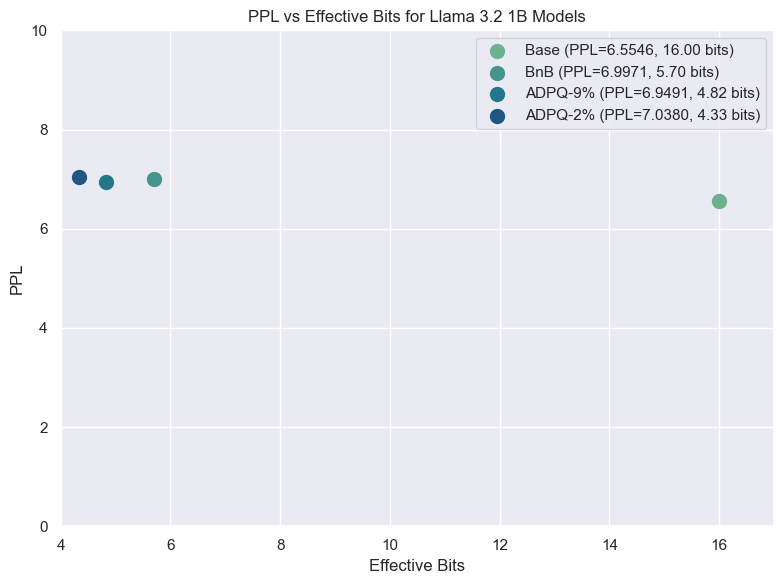

In [72]:
fig, ax = plt.subplots(figsize=(8,6))

PPL = {
    "Base":{
        "effective_bits": 16,
        "PPL": 6.5546
    },
    "BnB":{
        "effective_bits": SoTA["BnB"],
        "PPL": 6.9971
    },
    "ADPQ-9%":{
        "effective_bits": get_total_size_bytes(10**9, 4, 128, 0.09, False)[1],
        "PPL": 6.9491
    },
    "ADPQ-2%":{
        "effective_bits": get_total_size_bytes(10**9, 4, 128, 0.02, False)[1],
        "PPL": 7.0380
    }
}

colors = sns.color_palette("crest", len(PPL))
for i, (method, vals) in enumerate(PPL.items()):
    ax.scatter(vals["effective_bits"], vals["PPL"], label=f'{method} (PPL={vals["PPL"]:.4f}, {vals["effective_bits"]:.2f} bits)', s=100, color=colors[i])
    
ax.set_title('PPL vs Effective Bits for Llama 3.2 1B Models')
ax.set_xlabel('Effective Bits')
ax.set_ylabel('PPL')
ax.set_xlim(4,17)
ax.set_ylim(0,10)
ax.legend()
fig.tight_layout()

plt.savefig('figs/ppl_vs_effective_bits.png', dpi=300)
plt.savefig('figs/ppl_vs_effective_bits.pdf')